# Create dataset - attributes
***

**Autor:** Chus Casado Rodríguez<br>
**Date:** 03-06-2025<br>

**Introduction:**<br>
This code creates the basic table of static attributes for the reservoirs in ResOpsUS. The attributes will be taken from GRanD, but some information will be added from both ResOpsUS and GloFAS.

The resulting files are three:

* *glofas.csv* contains the storage and outflow limits used in the GloFASv4 simulations, and the two calibrated reservoir parameters.
* *grand.csv* contains the reservoir and dam characteristics extracted from GRanD, which will be later on used as the main static inputs in the modelling, and used to normalize the time series.
* *resops.csv* defines the variables and time span of the observed time series in ResOpsUS.

**To do:**<br>
* [x] Correct reservoir storage capacity.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from datetime import datetime, timedelta
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from lisfloodreservoirs.utils import DatasetConfig
from lisfloodreservoirs.utils.plots import plot_reservoir_map

## Configuration

In [2]:
cfg = DatasetConfig('config_ResOpsUS_v21.yml')

print(f'Attribute tables will be saved in {cfg.PATH_ATTRS}')

Attribute tables will be saved in Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsUS\v2.1\attributes


## Data

### ResOpsUS

#### Reservoirs

The ResOpsUS attributes includes 678 reservoirs
The ResOpsUS time series inventory includes 677 reservoirs


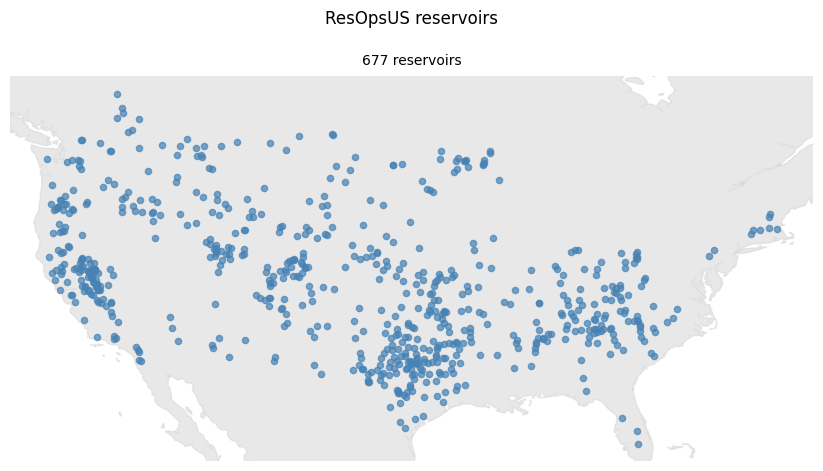

In [3]:
# load reservoir attributes
attributes = pd.read_csv(cfg.PATH_RESOPS / 'raw' / 'attributes' / 'reservoir_attributes.csv', index_col='DAM_ID')
attributes = attributes[~attributes.index.duplicated(keep='first')]
attributes.index.name = 'GRAND_ID'
print(f'The ResOpsUS attributes includes {attributes.shape[0]} reservoirs')

# load time series recorded for each reservoir
inventory = pd.read_csv(cfg.PATH_RESOPS / 'raw' / 'attributes' / 'time_series_inventory.csv', index_col='DAM_ID')
inventory = inventory[~inventory.index.duplicated(keep='first')]
inventory.index.name = 'GRAND_ID'
print(f'The ResOpsUS time series inventory includes {inventory.shape[0]} reservoirs')

# merge attributes and inventory and convert into geopandas
resops = pd.merge(attributes, inventory, left_index=True, right_index=True)
resops = gpd.GeoDataFrame(
    resops,
    geometry=gpd.points_from_xy(resops.LONG, resops.LAT),
    crs='EPSG:4326'
    )

# print('ResOpsUS contains {0} reservoirs.'.format(resops.shape[0]))
# variables = ['STORAGE', 'INFLOW', 'OUTFLOW']
# for var in variables:
#     print('{0} of those have {1} time series.'.format((resops[var] == 1).sum(),
#                                                       var.lower()))
# print('{0} of those include all those variales.'.format(resops[variables].all(axis=1).sum()))

plot_reservoir_map(
    geometry=resops.geometry,
    save=None,
    title='ResOpsUS reservoirs',
    size=20
)

#### Time series

In [4]:
variables = ['STORAGE', 'INFLOW', 'OUTFLOW', 'ELEVATION', 'EVAPORATION']

resops[variables] = 0
resops['CAP_RESOPS'] = np.nan
for grand_id in tqdm(resops.index):
    # load timeseries
    file = cfg.PATH_OBS_TS / f'ResOpsUS_{grand_id}.csv'
    if file.is_file():
        series = pd.read_csv(file, parse_dates=True, index_col='date')
        series.columns = series.columns.str.upper()
    else:
        print(f"{file} doesn't exist")
    # trim to GloFAS long run period
    series = series.loc[cfg.START:cfg.END]
    # remove duplicated index
    series = series[~series.index.duplicated(keep='first')]
    # remove empty series
    series.dropna(axis=1, how='all', inplace=True)
    resops.loc[grand_id, series.columns] = 1
    # identify available variables and the beginning and end of the time series
    resops.loc[grand_id, ['TIME_SERIES_START', 'TIME_SERIES_END']] = series.first_valid_index(), series.last_valid_index()
    for var in series.columns:
        resops.loc[grand_id, [f'{var}_START', f'{var}_END']] = series[var].first_valid_index(), series[var].last_valid_index()
    # maximum recorded storage
    if 'STORAGE' in series.columns:
        resops.loc[grand_id, 'CAP_RESOPS'] = series.STORAGE.max()
    
# remove reservoirs with no records
mask = resops[variables].sum(axis=1) > 0
resops = resops.loc[mask]

print(f'ResOpsUS contains records for {resops.shape[0]} reservoirs in the period from {cfg.START} to {cfg.END}')

for var in variables:
    print('{0} of those have {1} time series.'.format((resops[var] == 1).sum(),
                                                      var.lower()))
print('{0} of those include inflow, storage and outflow time series.'.format(resops[['INFLOW', 'STORAGE', 'OUTFLOW']].all(axis=1).sum()))

  0%|          | 0/677 [00:00<?, ?it/s]

ResOpsUS contains records for 676 reservoirs in the period from 1975-01-01 00:00:00 to None
625 of those have storage time series.
313 of those have inflow time series.
517 of those have outflow time series.
505 of those have elevation time series.
46 of those have evaporation time series.
283 of those include inflow, storage and outflow time series.


In [5]:
# # simplify column names
# resops.rename(columns={'AGENCY_CODE': 'AGENCY_COD',
#          'TIME_SERIES_START': 'TS_START',
#          'TIME_SERIES_END': 'TS_END',
#          'INCONSISTENCIES_NOTED': 'NOTES',
#          'STORAGE_START': 'STO_START',
#          'STORAGE_END': 'STO_END',
#          'DATA_SOURCE': 'STO_SOURCE',
#          'INFLOW_START': 'IN_START',
#          'INFLOW_END': 'IN_END',
#          'DATA_SOURCE.1': 'IN_SOURCE',
#          'OUTFLOW_START': 'OUT_START',
#          'OUTFLOW_END': 'OUT_END',
#          'DATA_SOURCE.2': 'OUT_SOURCE', 
#          'ELEVATION_START': 'ELE_START', 
#          'ELEVATION_END': 'ELE_END',
#          'DATA_SOURCE.3': 'ELE_SOURCE',
#          'EVAPORATION': 'EVAPORA',
#          'EVAPORATION_START': 'EVA_START', 
#          'EVAPORATION_END': 'EVA_END',
#          'DATA_SOURCE.4': 'EVA_SOURCE'},
#                  inplace=True)

# # export as shapefile
# path_GIS = cfg.PATH_RESOPS / 'GIS'
# if path_GIS.exists() is False:
#     path_GIS.mkdir()
# resops.to_file(path_GIS / 'reservoirs.shp')

### GloFAS

#### Reservoirs

GloFASv4 contains 685 reservoirs worldwide
655 of those reservoirs have a GRAND_ID assigned
121 of those reservoirs are in ResOpsUS


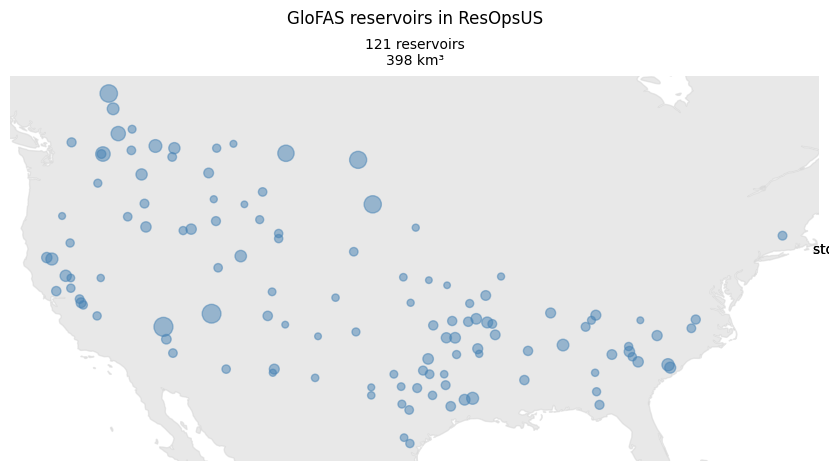

In [6]:
# load shapefile of GloFAS reservoirs
glofas = gpd.read_file(cfg.PATH_LISFLOOD / 'tables' / 'GloFAS_reservoirs.shp')
glofas.rename(columns={'stor': 'CAP_GLWD', 'ResID': 'GLOFAS_ID'}, inplace=True)
print(f'GloFASv4 contains {glofas.shape[0]} reservoirs worldwide')

# remove those without GRAND_ID
glofas = glofas.loc[~glofas.GRAND_ID.isnull()]
glofas.GRAND_ID = glofas.GRAND_ID.astype(int)
glofas.set_index('GRAND_ID', drop=False, inplace=True)
glofas.sort_index(axis=0, inplace=True)
print(f'{glofas.shape[0]} of those reservoirs have a GRAND_ID assigned')

# keep only reservoirs in ResOps
mask_resops = glofas.index.intersection(resops.index)
glofas = glofas.loc[mask_resops]
glofas.index.name = 'GRAND_ID'
print(f'{glofas.shape[0]} of those reservoirs are in ResOpsUS')

plot_reservoir_map(
    geometry=glofas.geometry,
    volume=glofas.CAP_GLWD,
    save=None,
    title='GloFAS reservoirs in ResOpsUS',
    alpha=.5
)

#### Reservoir model parameters

In [7]:
parameters = ['adjustNormalFlood', 'ReservoirRnormqMult']

# load static map of reservoirs
glofas_raster = xr.open_mfdataset((cfg.PATH_LISFLOOD / 'static_maps').glob('*reservoirs*.nc'))['res'].compute()

# extract an array of reservoir ID
ids = glofas.GLOFAS_ID.to_list()
ids.sort()

# xr.DataArrays of reservoir longitudes and latitudes
lon = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
lat = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
for ID in tqdm(ids):
    cell = glofas_raster.where(glofas_raster == ID, drop=True)
    lon.loc[dict(ResID=ID)] = cell.lon.data[0]
    lat.loc[dict(ResID=ID)] = cell.lat.data[0]
coords = xr.Dataset({'lon': lon, 'lat': lat})

# extract parameter values
map_glofas_id = {glofas_id: grand_id for grand_id, glofas_id in glofas.GLOFAS_ID.items()}
for par in parameters:
    # load parameter map
    da = xr.open_mfdataset((cfg.PATH_LISFLOOD / 'parameters').glob(f'{par}*.nc'))[par].compute()
    da = da.where(da != -9999, np.nan,)
    # extract values for each reservoir
    df = da.sel(lon=lon, lat=lat, method='nearest').drop_vars(['lon', 'lat']).to_pandas()
    df.rename(index=map_glofas_id, inplace=True)
    glofas[par] = df

# adjust normal limit and outflow with the calibrated parameters
glofas['nlim_adj'] = glofas.nlim + glofas.adjustNormalFlood * (glofas.flim - glofas.nlim)
glofas['normq_adj'] = pd.concat((glofas.normq * glofas.ReservoirRnormqMult, glofas.minq + .01), axis=1).max(axis=1)

  0%|          | 0/121 [00:00<?, ?it/s]

### GRanD


GraND contains 7320 reservoirs worldwide
676 reservoirs are both in ResOpsUS and GRanD
GRanD contains 676 out of 676 reservoirs in ResOpsUS.


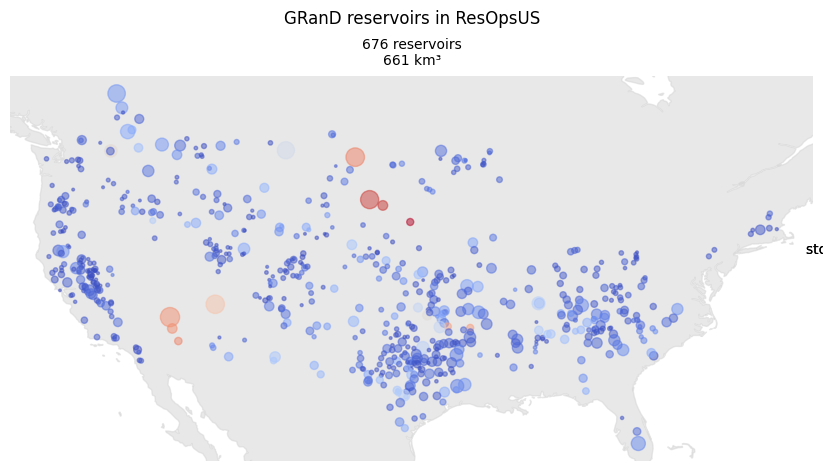

In [8]:
# load GRanD data set
grand = gpd.read_file(cfg.PATH_GRAND / 'grand_dams_v1_3.shp')
grand.set_index('GRAND_ID', drop=True, inplace=True)
grand = grand.replace(-99, np.nan)
print(f'GraND contains {grand.shape[0]} reservoirs worldwide')

# filter reservoirs present in ResOpsUS
grand = grand.loc[resops.index]
print(f'{grand.shape[0]} reservoirs are both in ResOpsUS and GRanD')
print('GRanD contains {0} out of {1} reservoirs in ResOpsUS.'.format(grand.shape[0], resops.shape[0]))

plot_reservoir_map(
    geometry=grand.geometry, 
    volume=grand.CAP_MCM, 
    area=grand.CATCH_SKM,
    save=None,
    title='GRanD reservoirs in ResOpsUS',
    alpha=.5,
)

In [16]:
# keep the maximum value of surface area, which is often
# AREA_REP and matches the National Inventory of Dams
# area_cols = [col for col in grand.columns if 'AREA' in col]
# grand['AREA_SKM'] = grand[area_cols].max(axis=1)
mask = grand.AREA_REP.notnull()
grand.loc[mask, 'AREA_SKM'] = grand.loc[mask, 'AREA_REP']

# define single use reservoirs
uses = [col for col in grand.columns if col.startswith('USE')]
mask_single_use = (~grand[uses].isnull()).sum(axis=1) == 1
grand['SINGLE_USE'] = 0
grand.loc[mask_single_use, 'SINGLE_USE'] = 1

# convert feature or individual uses into a ordinal encoder
grand[uses] = grand[uses].replace({None: 'None',
                                   'Maj': 'Major'})
grand[uses] = OrdinalEncoder(categories=[['None', 'Sec', 'Major', 'Main']] * len(uses)).fit_transform(grand[uses])

# one hot encoder of the main use
main_use = pd.DataFrame(grand.pop('MAIN_USE'))
main_use.columns = ['MAIN']
map_uses = {
    'Fisheries': 'FISH',
    'Flood control': 'FCON',
    'Hydroelectricity': 'ELEC',
    'Irrigation': 'IRRI',
    'Livestock': 'LIVE',
    'Navigation': 'NAVI',
    'Other': 'OTHR', 
    'Pollution control': 'PCON',
    'Recreation': 'RECR',
    'Water supply': 'SUPP',
    None: 'NONE'
}
main_use.replace(map_uses, inplace=True)
ohe = OneHotEncoder(sparse_output=False)
main_use_ohe = pd.DataFrame(ohe.fit_transform(main_use),
                            index=main_use.index,
                            columns=ohe.get_feature_names_out(['MAIN']))
main_use_ohe.drop('MAIN_NONE', axis=1, inplace=True)
grand = pd.concat((grand, main_use_ohe), axis=1)
grand.index.name = 'GRAND_ID'

## Static attributes

### Correct reservoir capacity

In [17]:
file = Path('fraction_fill.xlsx')
if file.is_file():
    # import DataFrame with the fraction fill and the selected data source
    ff = pd.read_excel(file, index_col='GRAND_ID')
else:
    # create DataFrame with the fraction fill according to each data source
    ff_ = pd.DataFrame(columns=['ResID', 'GLOFAS', 'GRAND'], dtype=float)
    ff_.index.name = 'GRAND_ID'
    for ID in grand.index:
        cap_resops = resops.loc[ID, 'CAP_RESOPS']
        if np.isnan(cap_resops):
            continue
        if ID in glofas.index:
            ff_.loc[ID, 'ResID'] = glofas.loc[ID, 'GLOFAS_ID']
            ff_.loc[ID, 'GLOFAS'] = cap_resops / glofas.loc[ID, 'CAP_GLWD']
        ff_.loc[ID, 'GRAND'] = cap_resops / grand.loc[ID, 'CAP_MCM']

    # export
    ff.to_excel(file, index=True)

# define the capacity  ('CAP') as that of the most reliable source
glofas['CAP'] = np.nan
for ID in ff.index:
    if ff.loc[ID, 'selection'] == 'GLOFAS':
        glofas.loc[ID, 'CAP'] = glofas.loc[ID, 'CAP_GLWD']
    elif ff.loc[ID, 'selection'] == 'GRAND':
        glofas.loc[ID, 'CAP'] = grand.loc[ID, 'CAP_MCM']

### Filter

In [18]:
mask_area = grand.CATCH_SKM >= cfg.MIN_AREA
mask_vol = grand.CAP_MCM >= cfg.MIN_VOL
len_ts = (resops.TIME_SERIES_END - resops.TIME_SERIES_START) / np.timedelta64(1, 'D')
mask_ts = len_ts >= cfg.MIN_YEARS * 365
mask = mask_area & mask_vol & mask_ts

print(f'{mask_area.sum()} reservoirs exceed the minimum catchment area of {cfg.MIN_AREA} km²')
print(f'{mask_vol.sum()} reservoirs exceed the minimum reservoir storage of {cfg.MIN_VOL} hm3')
print(f'{mask_ts.sum()} reservoirs exceed the minimum time series lenght of {cfg.MIN_YEARS} years')
print(f'{mask.sum()} reservoirs fulfil all the conditions above')

636 reservoirs exceed the minimum catchment area of 50 km²
675 reservoirs exceed the minimum reservoir storage of 10 hm3
664 reservoirs exceed the minimum time series lenght of 4 years
626 reservoirs fulfil all the conditions above


### GRanD

In [19]:
attrs_grand = ['RES_NAME', 'DAM_NAME', 'ALT_NAME', 'RIVER', 'ALT_RIVER', 'MAIN_BASIN', 'SUB_BASIN', 'NEAR_CITY', 'ALT_CITY', 'ADMIN_UNIT', 'SEC_ADMIN',
               'COUNTRY', 'SEC_CNTRY', 'YEAR', 'ALT_YEAR', 'REM_YEAR', 'DAM_HGT_M', 'ALT_HGT_M', 'DAM_LEN_M', 'ALT_LEN_M', 'AREA_SKM', 'CAP_MCM',
               'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL', 'CATCH_SKM', 'DATA_INFO', 'USE_IRRI', 'USE_ELEC', 'USE_SUPP', 'USE_FCON', 'USE_RECR',
               'USE_NAVI', 'USE_FISH', 'USE_PCON', 'USE_LIVE', 'USE_OTHR', 'SINGLE_USE', 'MAIN_ELEC', 'MAIN_FCON', 'MAIN_FISH', 'MAIN_IRRI',
               'MAIN_NAVI', 'MAIN_OTHR', 'MAIN_RECR', 'MAIN_SUPP', 'LAKE_CTRL', 'MULTI_DAMS', 'TIMELINE', 'COMMENTS', 'QUALITY', 'LONG_DD', 'LAT_DD']
# grand_export = grand.loc[mask, attrs_grand].copy()
grand_export = grand.loc[:, attrs_grand].copy()
grand_export.index.name = 'GRAND_ID'
grand_export.sort_index(axis=0, inplace=True)
grand_export.sort_index(axis=1, inplace=True)
grand_export.rename(columns={'LONG_DD': 'LON',
                             'LAT_DD': 'LAT'},
                    inplace=True)
grand_export.dropna(axis=1, how='all', inplace=True)

# export
grand_export.to_csv(cfg.PATH_ATTRS / 'grand.csv')

##### `lfcoords`

CSV needed as input to locate the reservoirs in the LISFLOOD grid using the `lfcoords` utility.

In [20]:
# select info
lfcoords = grand[['CATCH_SKM', 'LAT_DD', 'LONG_DD']].copy()
lfcoords.rename(columns={'CATCH_SKM': 'area', 'LAT_DD': 'lat', 'LONG_DD': 'lon'}, inplace=True)
lfcoords.index.name = 'ID'

# export
path_lfcoords = cfg.PATH_RESOPS / 'ancillary' / 'lfcoords'
path_lfcoords.mkdir(exist_ok=True, parents=True)
lfcoords.to_csv(path_lfcoords / f'reservoirs_{len(lfcoords)}.csv')

### ResOpsUS

In [21]:
attrs_resops = ['CAP_RESOPS', 'ELEVATION', 'ELEVATION_END', 'ELEVATION_START',
                'EVAPORATION', 'EVAPORATION_END', 'EVAPORATION_START',
                'INCONSISTENCIES_NOTED', 'INFLOW', 'INFLOW_END', 'INFLOW_START',
                'OUTFLOW', 'OUTFLOW_END', 'OUTFLOW_START', 'STATE',
                'STORAGE', 'STORAGE_END', 'STORAGE_START',
                'TIME_SERIES_END', 'TIME_SERIES_START']
# resops_export = resops.loc[mask, attrs_resops].copy()
resops_export = resops.loc[:, attrs_resops].copy()
resops_export.index.name = 'GRAND_ID'
resops_export.sort_index(axis=0, inplace=True)
resops_export.sort_index(axis=1, inplace=True)
resops_export.dropna(axis=1, how='all', inplace=True)

# export
resops_export.to_csv(cfg.PATH_ATTRS / 'resops.csv')

### GloFAS

In [22]:
attrs_glofas = ['CAP', 'CAP_GLWD', 'GLOFAS_ID', 'GLWD_ID', 'LisfloodX3', 'LisfloodY3',
                'ReservoirRnormqMult', 'adjustNormalFlood', 'clim', 'flim', 'minq',
                'ndq', 'nlim', 'nlim_adj', 'normq', 'normq_adj']
# glofas_export = glofas.loc[mask, attrs_glofas].copy()
glofas_export = glofas.loc[:, attrs_glofas].copy()
glofas_export.index.name = 'GRAND_ID'
glofas_export.dropna(axis=1, how='all', inplace=True)
glofas_export.rename(columns={'LisfloodX3': 'LON_LISFLOOD',
                              'LisfloodY3': 'LAT_LISFLOOD',
                              'clim': 'Vmin',
                              'flim': 'Vf',
                              'minq': 'Qmin',
                              'ndq': 'Qf',
                              'nlim': 'Vn',
                              'nlim_adj': 'Vn_adj',
                              'normq': 'Qn',
                              'normq_adj': 'Qn_adj'},
                     inplace=True)
glofas_export.sort_index(axis=0, inplace=True)
glofas_export.sort_index(axis=1, inplace=True)

# export
glofas_export.to_csv(cfg.PATH_ATTRS / 'glofas.csv')